# Code to build ML models on the diabetes dataset

In [1]:
# Packages to be installed
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns # For better plots

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, \
                            ConfusionMatrixDisplay, RocCurveDisplay, f1_score, precision_score, recall_score, average_precision_score

# Classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.svm import SVC # Support Vector Machine
from sklearn.naive_bayes import GaussianNB # Naive Bayes
from sklearn.neighbors import KNeighborsClassifier # K-Nearest Neighbors
from sklearn.neural_network import MLPClassifier # Multi-layer Perceptron

# For handling imbalanced data
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline # Use imblearn's Pipeline for resampling steps

# For SHAP explanations
import shap
import joblib # For saving models

/Users/piyusm/Documents/Github_Repo/SUGAR/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


--- Data Loaded Successfully ---
   gender   age  hypertension  heart_disease smoking_history    bmi  \
0  Female  80.0             0              1           never  25.19   
1  Female  54.0             0              0         No Info  27.32   
2    Male  28.0             0              0           never  27.32   
3  Female  36.0             0              0         current  23.45   
4    Male  76.0             1              1         current  20.14   

   HbA1c_level  blood_glucose_level  diabetes  
0          6.6                  140         0  
1          6.6                   80         0  
2          5.7                  158         0  
3          5.0                  155         0  
4          4.8                  155         0  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 9 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   gender               100000 non-null

/var/folders/78/vykvv3p5317_39fydydf88y80000gn/T/ipykernel_23326/3231456401.py:92: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y_train, palette='viridis', ax=axes[0])
/var/folders/78/vykvv3p5317_39fydydf88y80000gn/T/ipykernel_23326/3231456401.py:98: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y_test, palette='viridis', ax=axes[1])


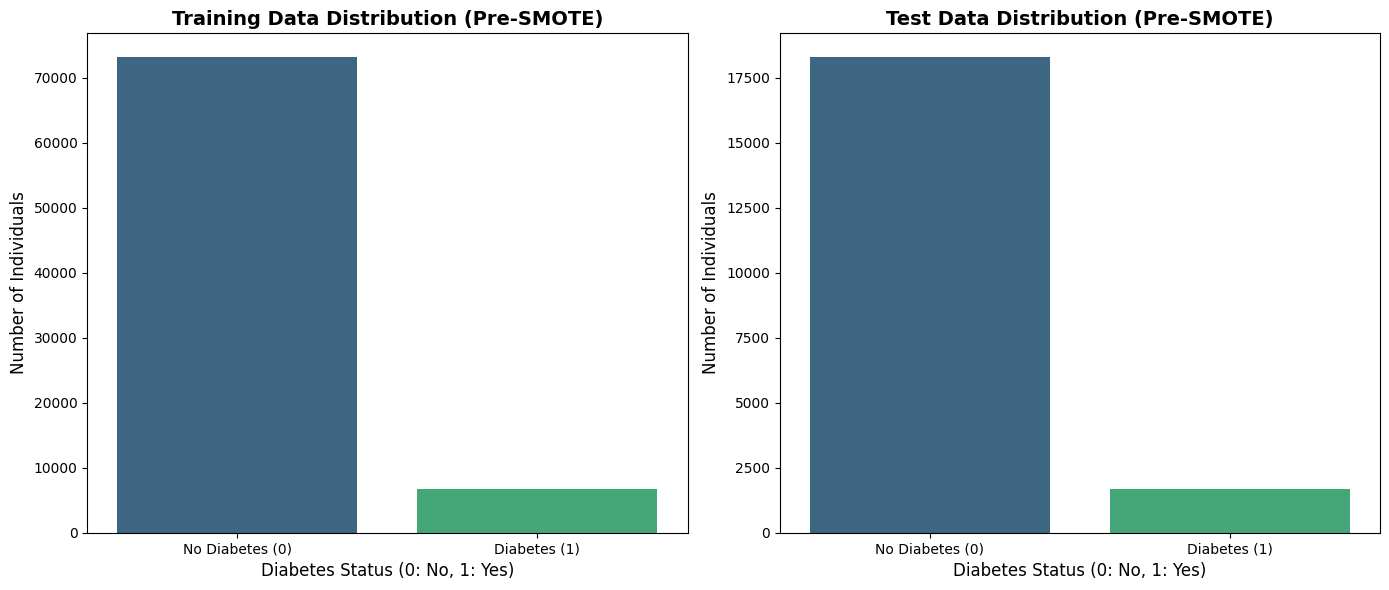


--- Applying Preprocessing and SMOTE to Training Data for Visualization (Post-SMOTE) ---

--- Class Distribution AFTER SMOTE (Training Set Only) ---
Training set distribution AFTER SMOTE:
diabetes
1    73200
0    73200
Name: count, dtype: int64
diabetes
1    50.0%
0    50.0%
Name: proportion, dtype: object


/var/folders/78/vykvv3p5317_39fydydf88y80000gn/T/ipykernel_23326/3231456401.py:128: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y_train_resampled_plot, palette='viridis')


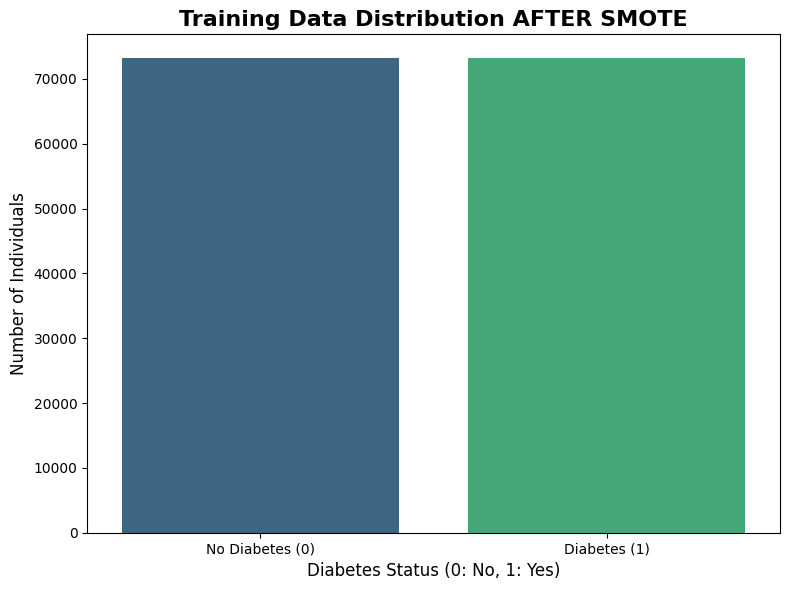


--- 6. Training and Evaluating Models ---

Training model: Logistic Regression...
  Accuracy: 0.8888
  ROC AUC: 0.9629
  Precision (Class 1): 0.4264
  Recall (Class 1): 0.8935
  F1-score (Class 1): 0.5773

Training model: Random Forest...
  Accuracy: 0.9695
  ROC AUC: 0.9621
  Precision (Class 1): 0.9311
  Recall (Class 1): 0.6918
  F1-score (Class 1): 0.7938

Training model: XGBoost...


/Users/piyusm/Documents/Github_Repo/SUGAR/.venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [14:15:46] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


  Accuracy: 0.9206
  ROC AUC: 0.9769
  Precision (Class 1): 0.5192
  Recall (Class 1): 0.8900
  F1-score (Class 1): 0.6558

Training model: LightGBM...
[LightGBM] [Info] Number of positive: 6800, number of negative: 73200
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001682 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 418
[LightGBM] [Info] Number of data points in the train set: 80000, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.085000 -> initscore=-2.376273
[LightGBM] [Info] Start training from score -2.376273


/Users/piyusm/Documents/Github_Repo/SUGAR/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/piyusm/Documents/Github_Repo/SUGAR/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


  Accuracy: 0.9152
  ROC AUC: 0.9789
  Precision (Class 1): 0.5006
  Recall (Class 1): 0.9082
  F1-score (Class 1): 0.6455

Training model: CatBoost...
  Accuracy: 0.9241
  ROC AUC: 0.9779
  Precision (Class 1): 0.5322
  Recall (Class 1): 0.8853
  F1-score (Class 1): 0.6648

Training model: SVM (RBF Kernel)...
  Accuracy: 0.8963
  ROC AUC: 0.9688
  Precision (Class 1): 0.4465
  Recall (Class 1): 0.9188
  F1-score (Class 1): 0.6010

Training model: Naive Bayes (with SMOTE)...
  Accuracy: 0.4682
  ROC AUC: 0.9128
  Precision (Class 1): 0.1368
  Recall (Class 1): 0.9900
  F1-score (Class 1): 0.2404

Training model: K-Nearest Neighbors (with SMOTE)...
  Accuracy: 0.9116
  ROC AUC: 0.9119
  Precision (Class 1): 0.4880
  Recall (Class 1): 0.8029
  F1-score (Class 1): 0.6071

Training model: Gradient Boosting (with SMOTE)...
  Accuracy: 0.9544
  ROC AUC: 0.9762
  Precision (Class 1): 0.7119
  Recall (Class 1): 0.7776
  F1-score (Class 1): 0.7433

Training model: MLP Classifier (with SMOTE)...

/Users/piyusm/Documents/Github_Repo/SUGAR/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/piyusm/Documents/Github_Repo/SUGAR/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


  Accuracy: 0.9702
  ROC AUC: 0.9782
  Precision (Class 1): 0.9207
  Recall (Class 1): 0.7106
  F1-score (Class 1): 0.8021

✅ Best Model identified by ROC AUC: LightGBM with ROC AUC = 0.9789

--- Combined Model Performance Metrics ---
                           Model  Accuracy  ROC AUC  Precision (Class 1)  Recall (Class 1)  F1-Score (Class 1)
                        LightGBM    0.9152   0.9789               0.5006            0.9082              0.6455
           LightGBM (with SMOTE)    0.9702   0.9782               0.9207            0.7106              0.8021
                        CatBoost    0.9241   0.9779               0.5322            0.8853              0.6648
                         XGBoost    0.9206   0.9769               0.5192            0.8900              0.6558
  Gradient Boosting (with SMOTE)    0.9544   0.9762               0.7119            0.7776              0.7433
     MLP Classifier (with SMOTE)    0.9210   0.9718               0.5213            0.8553         

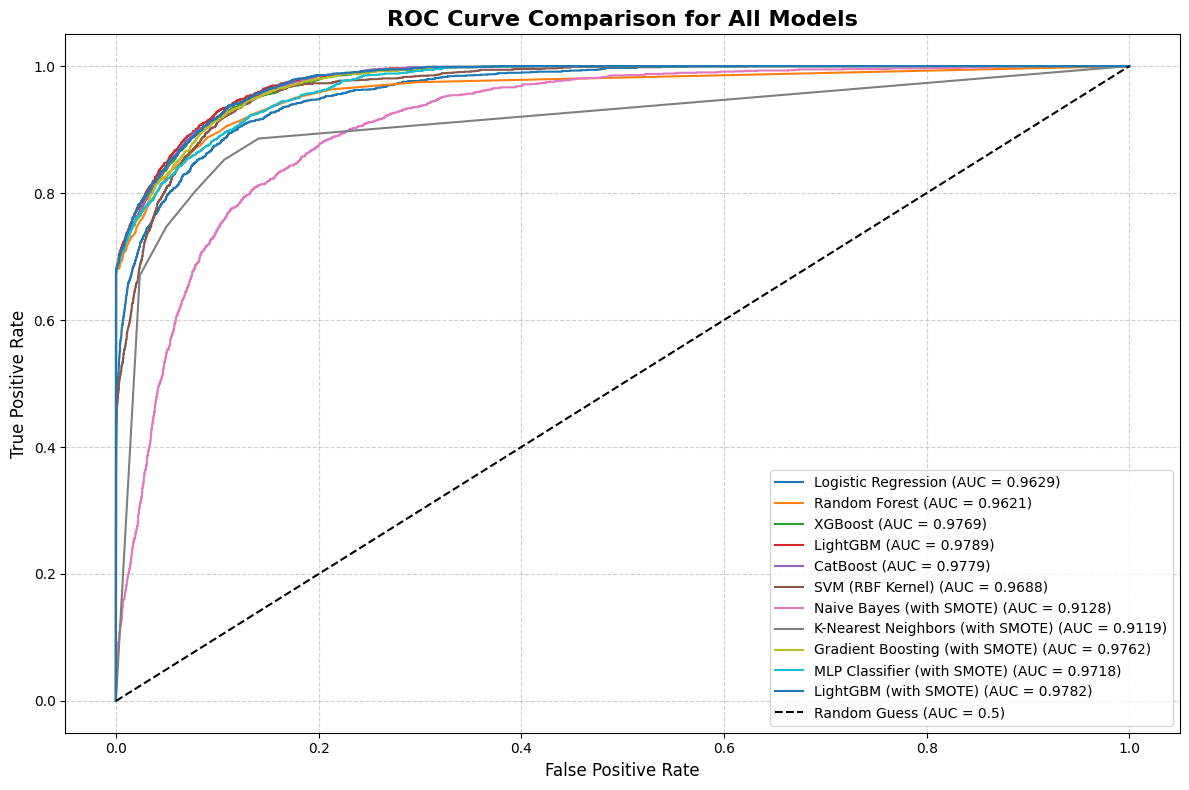


--- Visualizing Logistic Regression ---


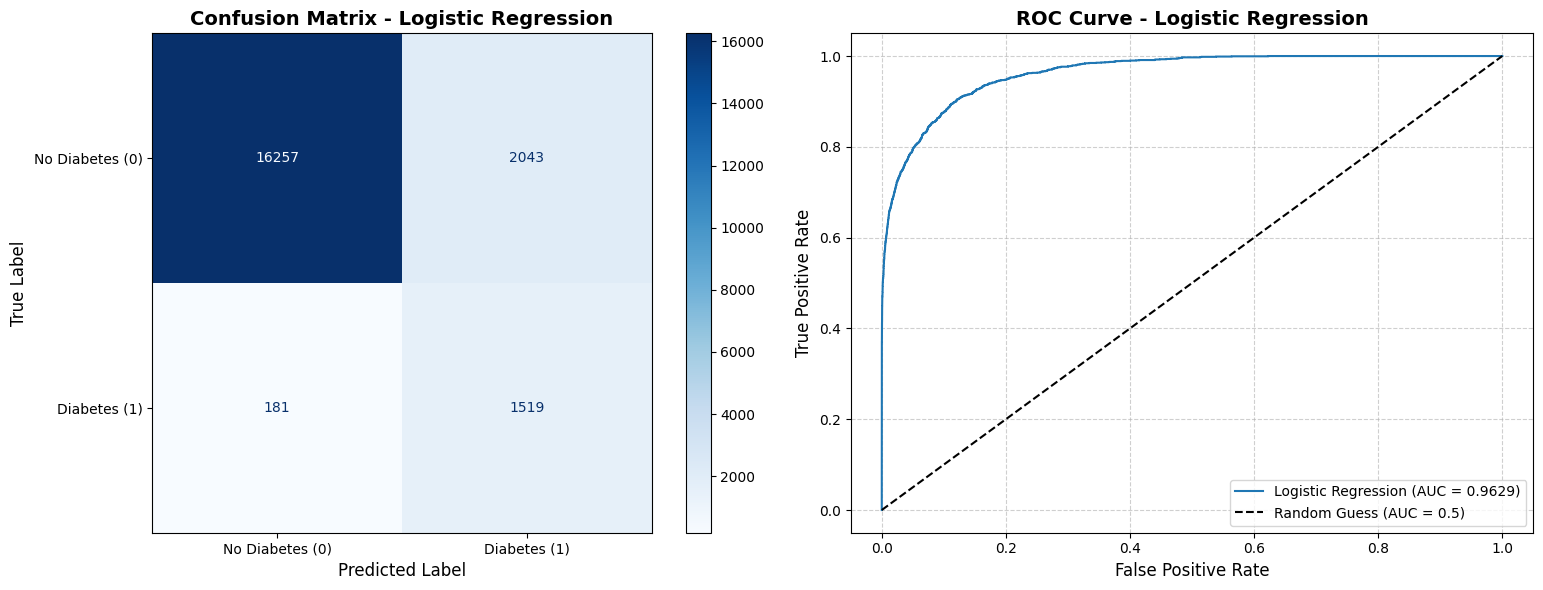


--- Visualizing Random Forest ---


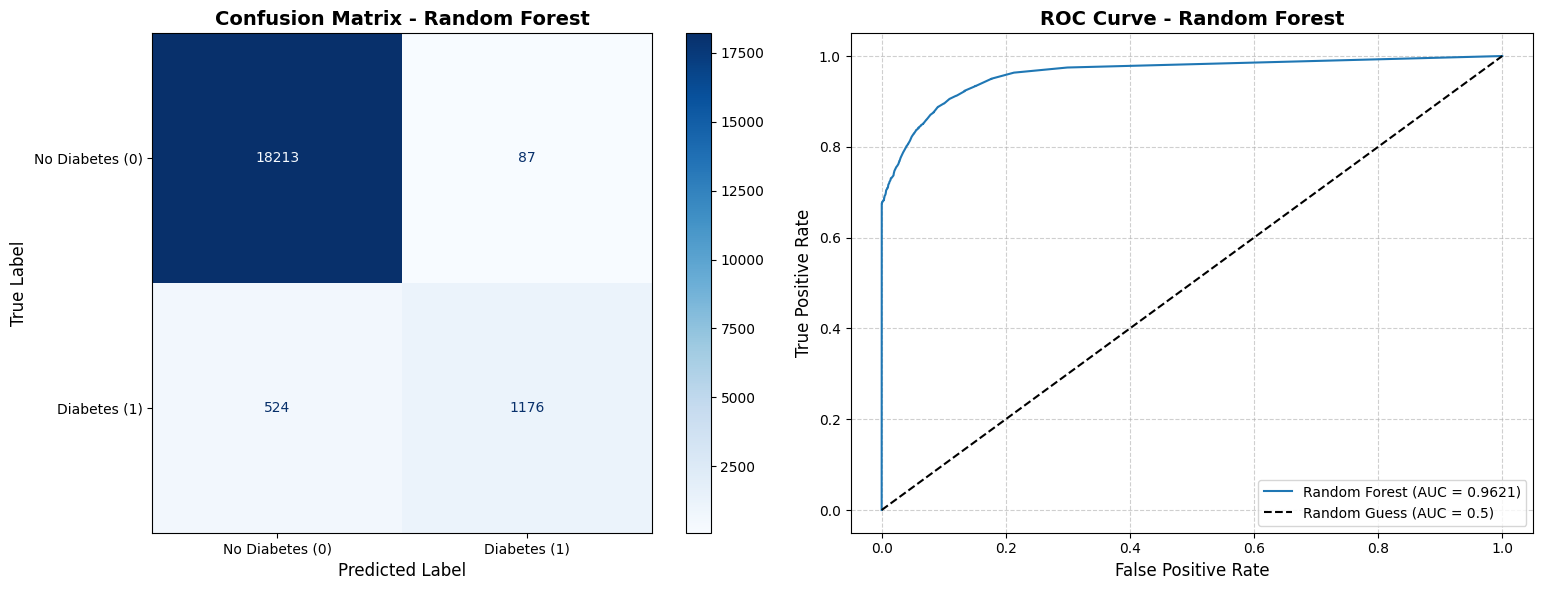


--- Visualizing XGBoost ---


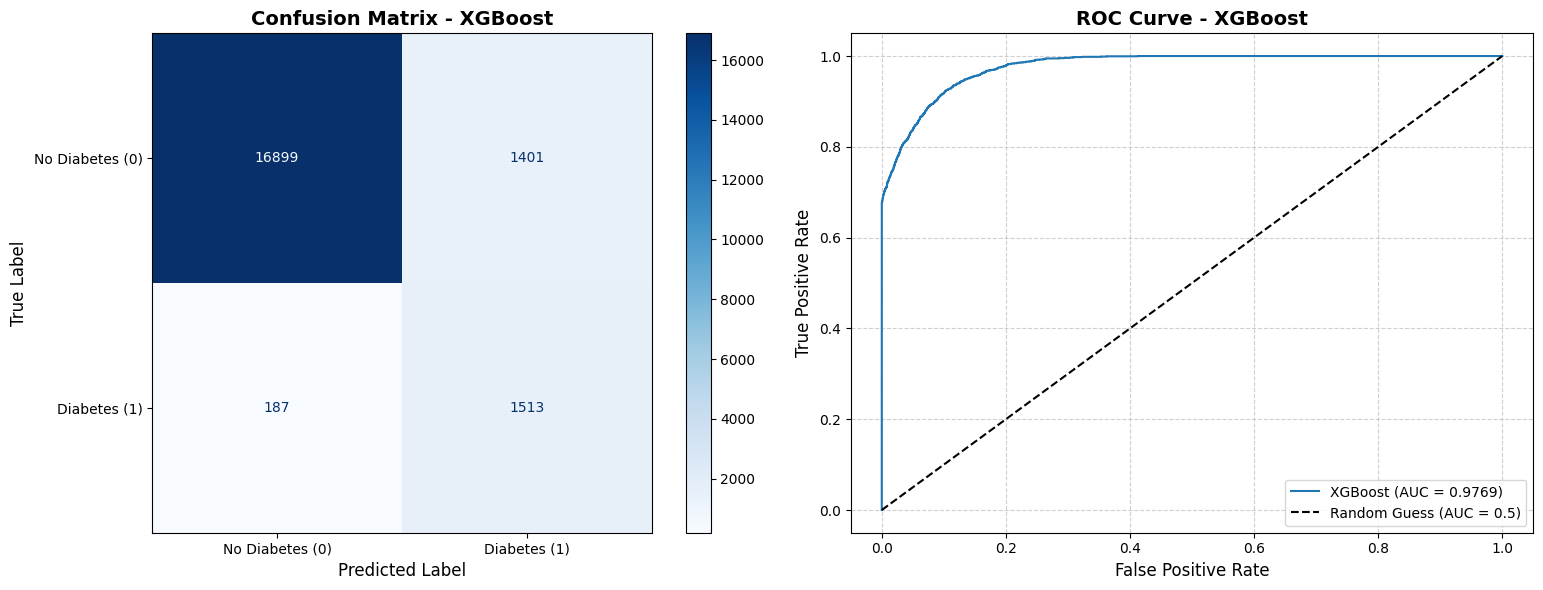


--- Visualizing LightGBM ---


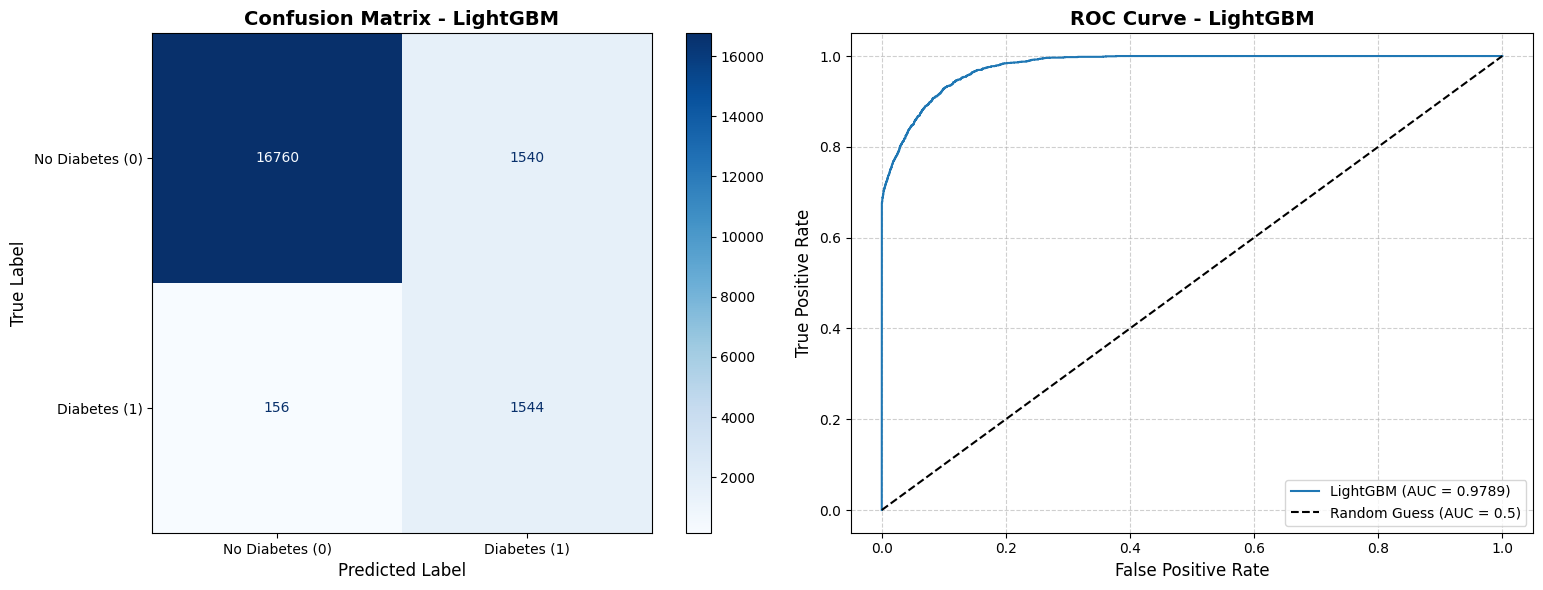


--- Visualizing CatBoost ---


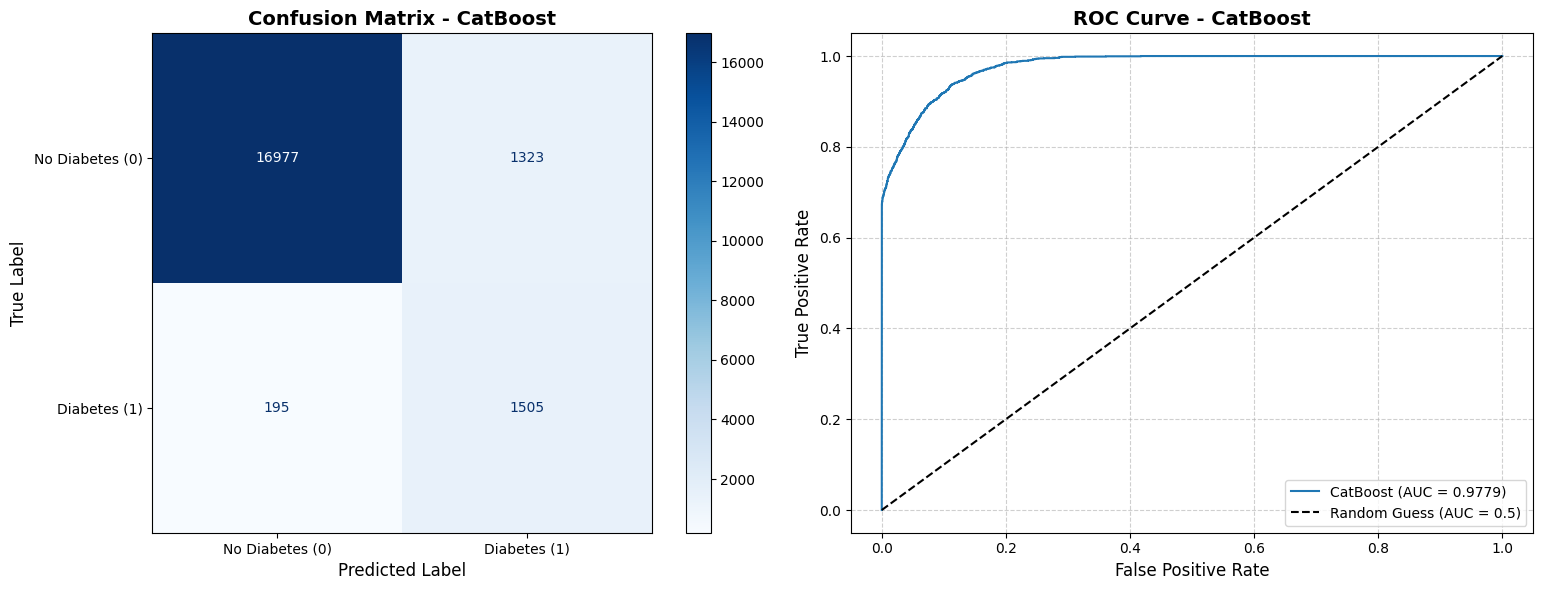


--- Visualizing SVM (RBF Kernel) ---


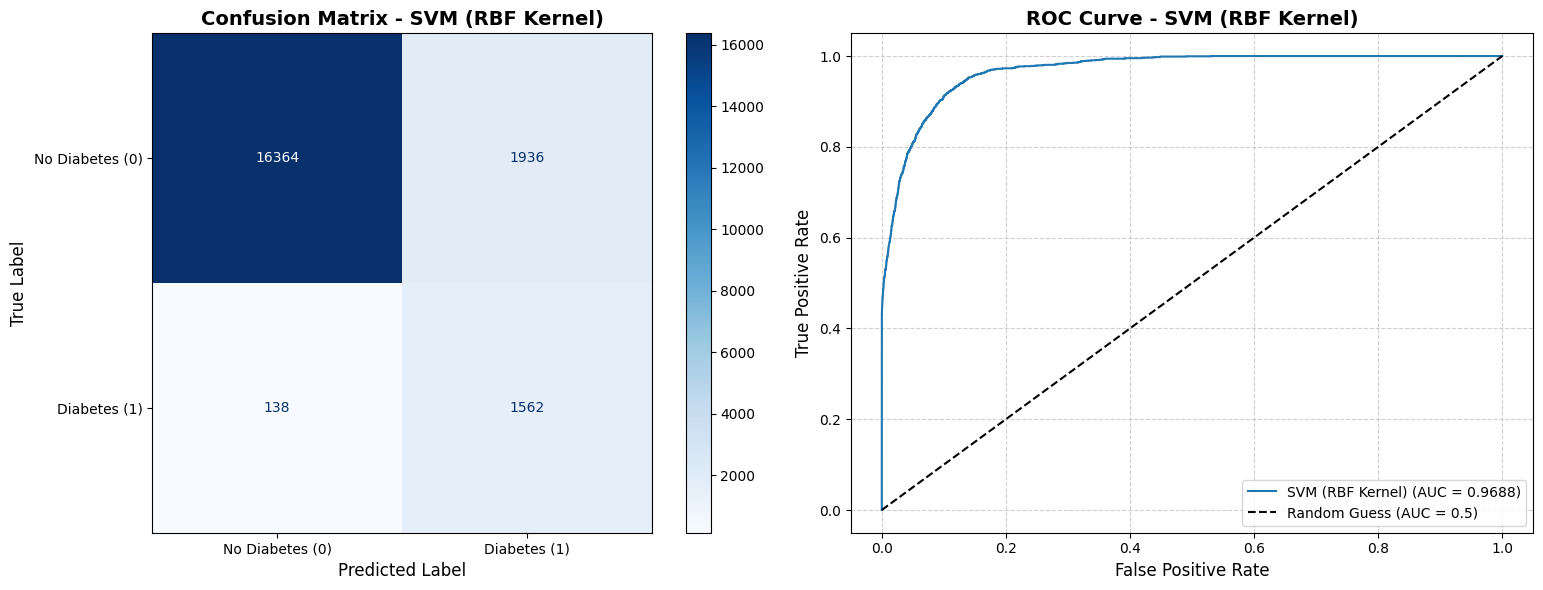


--- Visualizing Naive Bayes (with SMOTE) ---


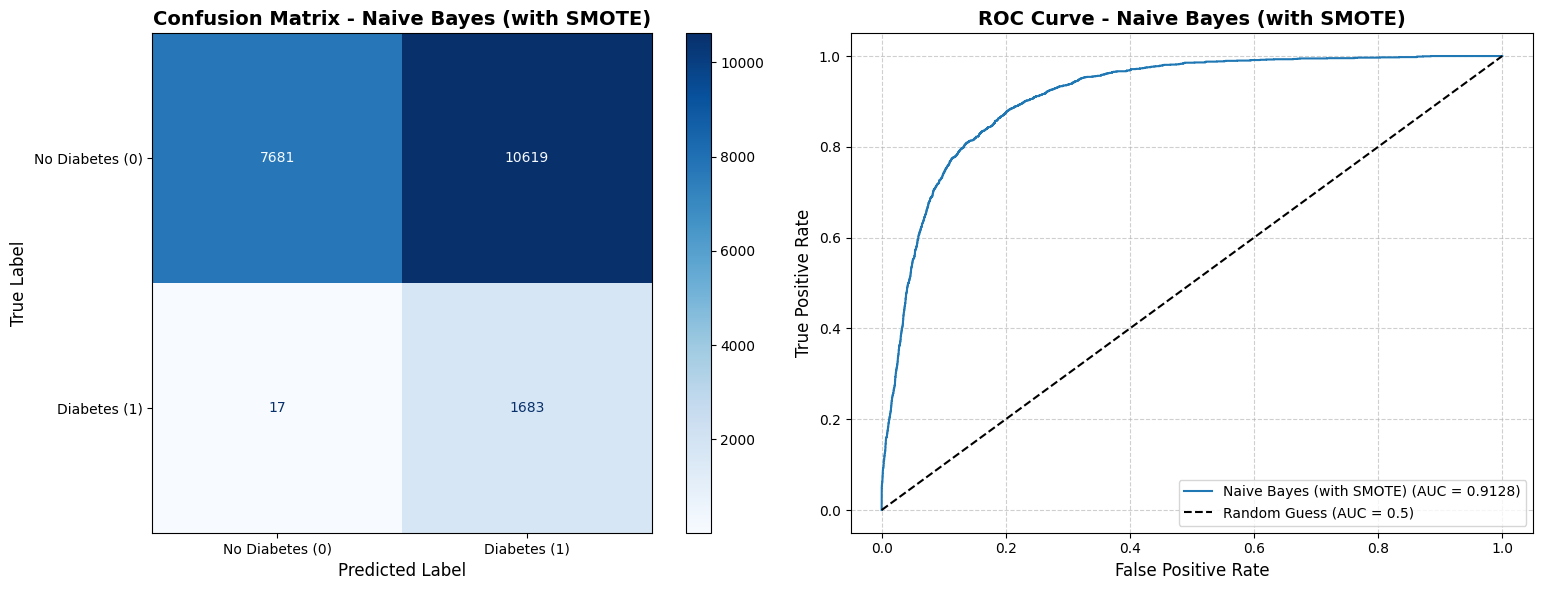


--- Visualizing K-Nearest Neighbors (with SMOTE) ---


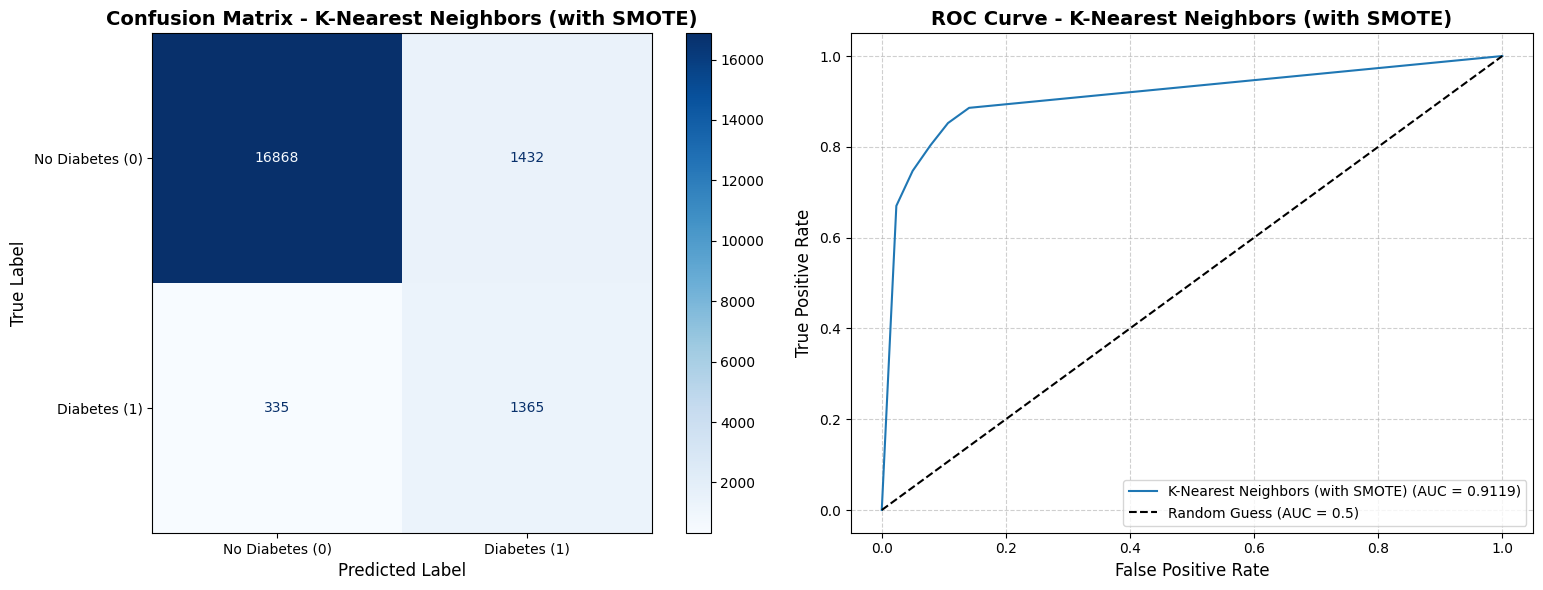


--- Visualizing Gradient Boosting (with SMOTE) ---


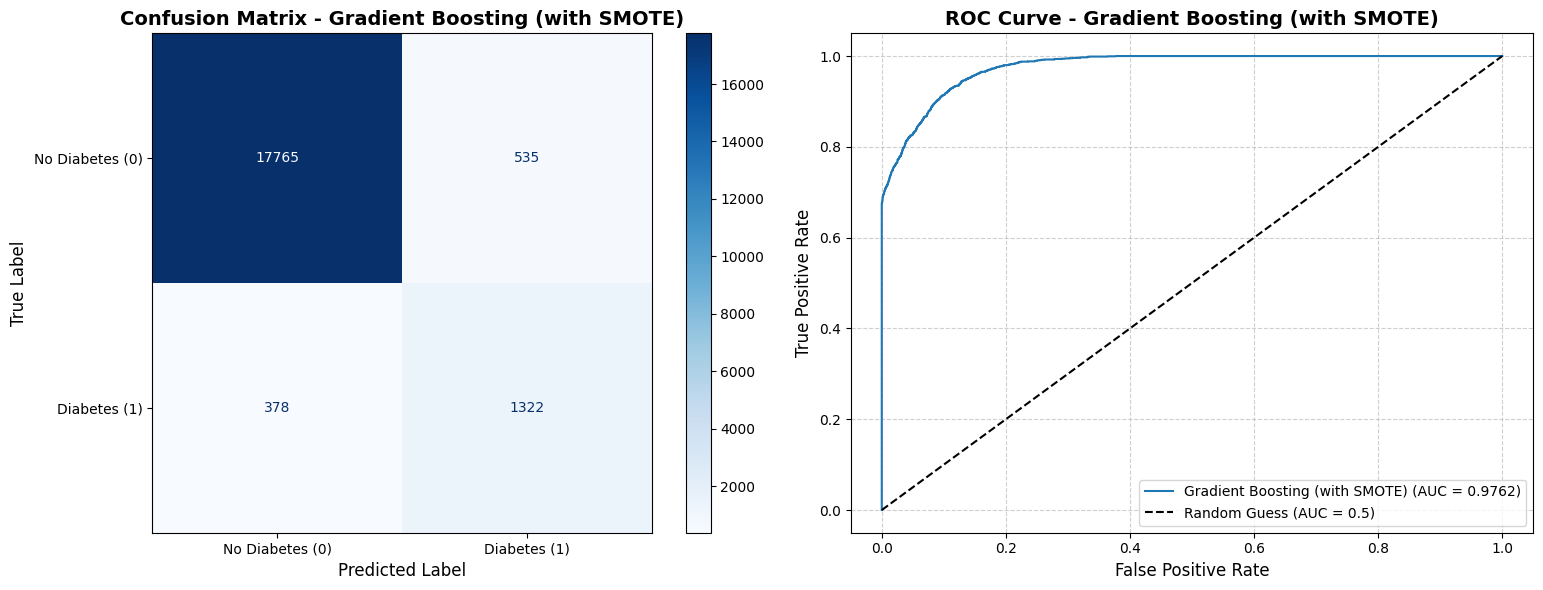


--- Visualizing MLP Classifier (with SMOTE) ---


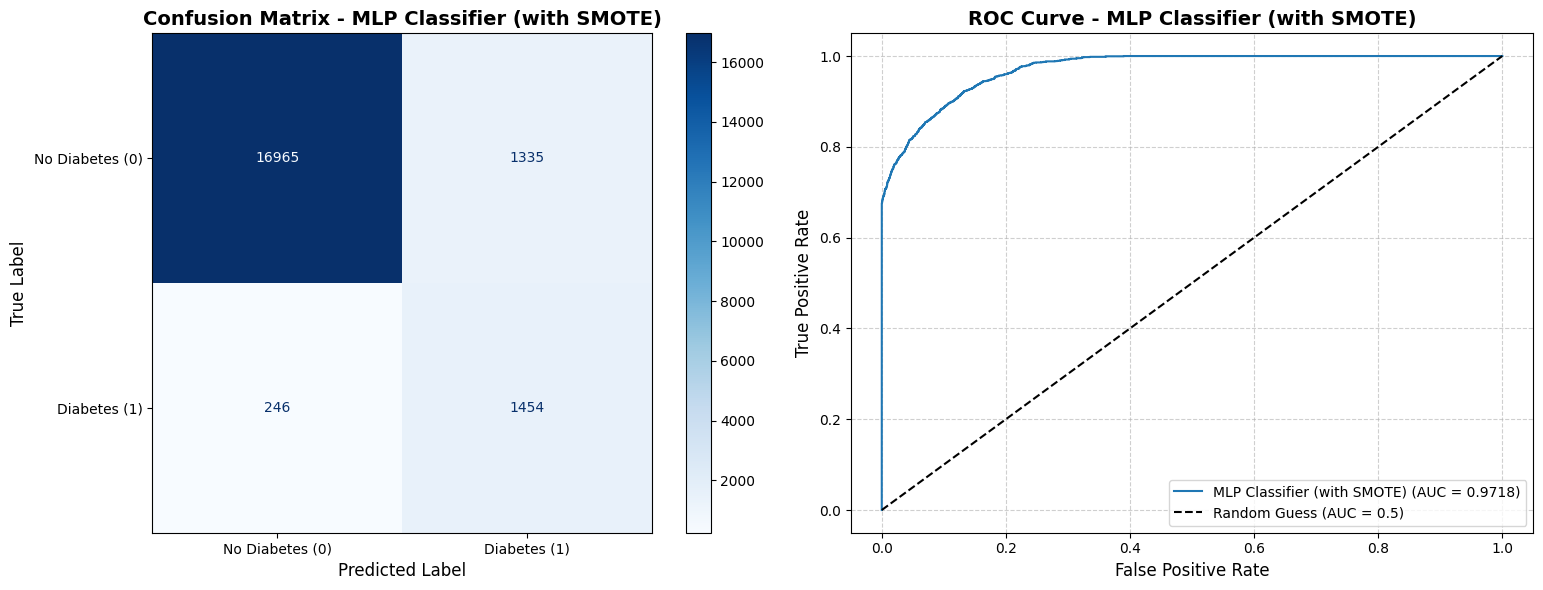


--- Visualizing LightGBM (with SMOTE) ---


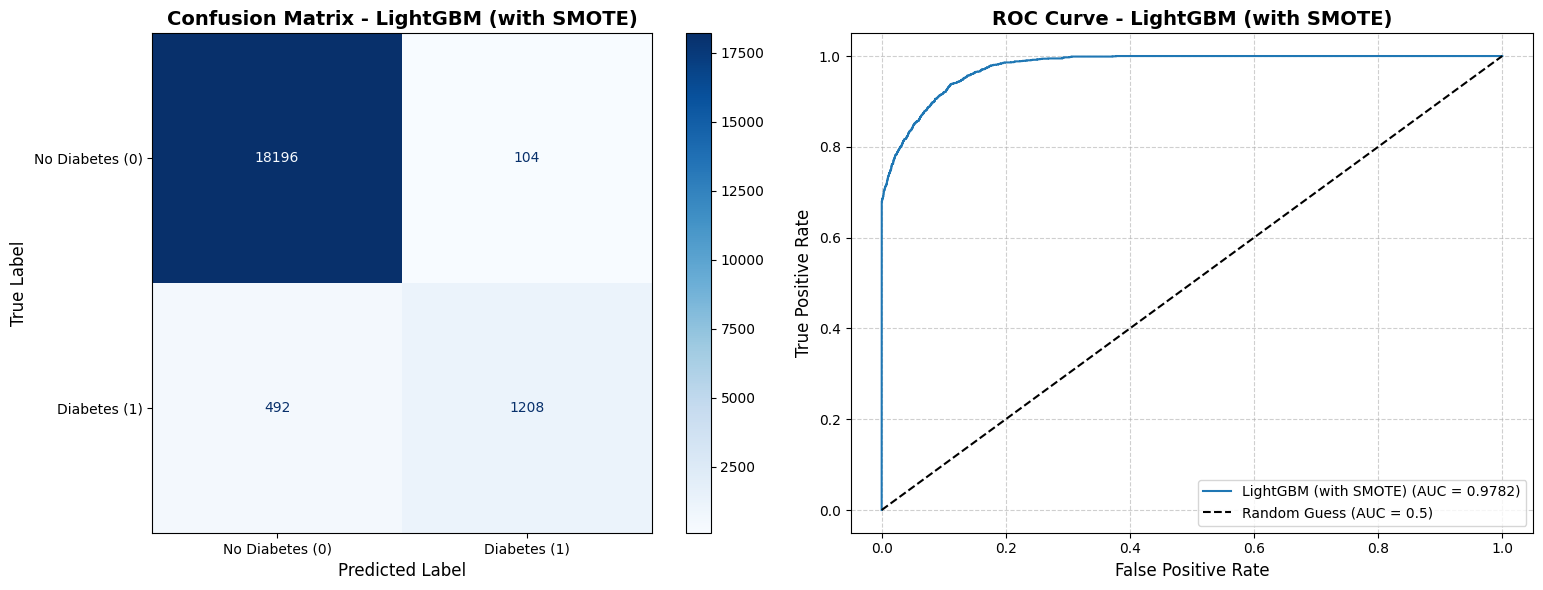


--- SHAP Explanation for the Best Model: LightGBM ---


/Users/piyusm/Documents/Github_Repo/SUGAR/.venv/lib/python3.10/site-packages/shap/explainers/_tree.py:583: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


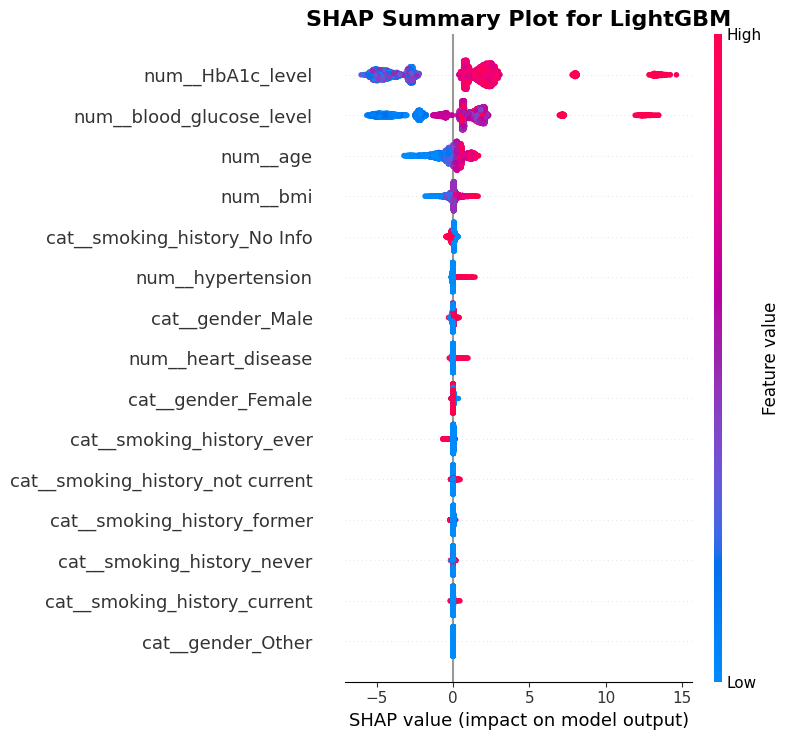


--- Saving the Best Model: LightGBM ---
Model saved as 'LightGBM_model.pkl'


In [2]:


# --- 1. Load Data ---
try:
    df = pd.read_csv("diabetes_prediction_dataset.csv")
    print("--- Data Loaded Successfully ---")
    print(df.head())
    print(df.info())
except FileNotFoundError:
    print("Error: 'diabetes_prediction_dataset.csv' not found.")
    print("Please ensure the CSV file is in the correct directory or provide the full path.")
    print("Generating synthetic data for demonstration as file not found...")
    # Generate synthetic data for demonstration if file not found
    np.random.seed(42)
    n_healthy = 91500
    n_diabetes = 8500
    df = pd.concat([
        pd.DataFrame({
            'gender': np.random.choice(['Female', 'Male'], n_healthy),
            'age': np.random.normal(40, 15, n_healthy).clip(20, 90).astype(int),
            'hypertension': np.random.choice([0, 1], n_healthy, p=[0.9, 0.1]),
            'heart_disease': np.random.choice([0, 1], n_healthy, p=[0.95, 0.05]),
            'smoking_history': np.random.choice(['never', 'No Info', 'former', 'current', 'ever'], n_healthy, p=[0.5, 0.2, 0.1, 0.1, 0.1]),
            'bmi': np.random.normal(25, 5, n_healthy).clip(15, 50),
            'HbA1c_level': np.random.normal(5.5, 0.5, n_healthy).clip(4.0, 7.0),
            'blood_glucose_level': np.random.normal(100, 20, n_healthy).clip(70, 200).astype(int),
            'diabetes': np.zeros(n_healthy).astype(int)
        }),
        pd.DataFrame({
            'gender': np.random.choice(['Female', 'Male'], n_diabetes),
            'age': np.random.normal(60, 10, n_diabetes).clip(30, 90).astype(int),
            'hypertension': np.random.choice([0, 1], n_diabetes, p=[0.3, 0.7]),
            'heart_disease': np.random.choice([0, 1], n_diabetes, p=[0.6, 0.4]),
            'smoking_history': np.random.choice(['current', 'former', 'ever', 'never', 'No Info'], n_diabetes, p=[0.4, 0.3, 0.2, 0.05, 0.05]),
            'bmi': np.random.normal(30, 7, n_diabetes).clip(20, 60),
            'HbA1c_level': np.random.normal(7.5, 0.8, n_diabetes).clip(6.0, 10.0),
            'blood_glucose_level': np.random.normal(200, 50, n_diabetes).clip(140, 300).astype(int),
            'diabetes': np.ones(n_diabetes).astype(int)
        })
    ], ignore_index=True).sample(frac=1, random_state=42).reset_index(drop=True)

    for col in ['bmi', 'HbA1c_level', 'blood_glucose_level']:
        missing_indices = np.random.choice(df.index, size=int(len(df) * 0.01), replace=False)
        df.loc[missing_indices, col] = np.nan
    missing_cat_indices = np.random.choice(df.index, size=int(len(df) * 0.005), replace=False)
    df.loc[missing_cat_indices, 'smoking_history'] = np.nan

# Drop rows where 'diabetes' target itself is NaN (if any)
df.dropna(subset=["diabetes"], inplace=True) # Ensure target column has no NaNs
X = df.drop(columns="diabetes")
y = df["diabetes"]

# --- 2. Initial Data Analysis (Missing Values and Class Imbalance) ---
print("\n--- Missing Values Count (Before Imputation) ---")
missing_counts = df.isnull().sum()
print(missing_counts[missing_counts > 0])

# --- 3. Column Identification & Preprocessing Pipelines ---
categorical_cols = X.select_dtypes(include=["object"]).columns.tolist()
numerical_cols = X.select_dtypes(include=["number"]).columns.tolist()

numerical_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="mean")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False)) # sparse_output=False for SHAP compatibility
])

preprocessor = ColumnTransformer([
    ("num", numerical_transformer, numerical_cols),
    ("cat", categorical_transformer, categorical_cols)
])

# --- 4. Train/Test Split (Stratified is CRUCIAL) ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# --- Display Pre-SMOTE Distributions ---
print("\n--- Class Distributions BEFORE SMOTE ---")
print("Training set distribution:")
print(y_train.value_counts())
print(y_train.value_counts(normalize=True).mul(100).round(2).astype(str) + '%')

print("\nTest set distribution:")
print(y_test.value_counts())
print(y_test.value_counts(normalize=True).mul(100).round(2).astype(str) + '%')

# Visualize Class Imbalance (Pre-SMOTE)
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
sns.countplot(x=y_train, palette='viridis', ax=axes[0])
axes[0].set_title('Training Data Distribution (Pre-SMOTE)', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Diabetes Status (0: No, 1: Yes)', fontsize=12)
axes[0].set_ylabel('Number of Individuals', fontsize=12)
axes[0].set_xticks(ticks=[0, 1], labels=['No Diabetes (0)', 'Diabetes (1)'])

sns.countplot(x=y_test, palette='viridis', ax=axes[1])
axes[1].set_title('Test Data Distribution (Pre-SMOTE)', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Diabetes Status (0: No, 1: Yes)', fontsize=12)
axes[1].set_ylabel('Number of Individuals', fontsize=12)
axes[1].set_xticks(ticks=[0, 1], labels=['No Diabetes (0)', 'Diabetes (1)'])
plt.tight_layout()
plt.show()


# --- Apply SMOTE for Post-SMOTE Visualization ---
print("\n--- Applying Preprocessing and SMOTE to Training Data for Visualization (Post-SMOTE) ---")
smote_instance_for_plot = SMOTE(sampling_strategy='auto', random_state=42)
smote_pipeline_for_plotting = ImbPipeline([
    ("preprocessor", preprocessor),
    ("smote", smote_instance_for_plot)
])

# Fit and transform X_train, y_train to get the resampled data for plotting
# Note: X_train_resampled_plot is used only for plotting the distribution,
# the actual models use their internal pipelines which handle SMOTE if specified.
X_train_resampled_plot, y_train_resampled_plot = smote_pipeline_for_plotting.fit_resample(X_train, y_train)

# --- Display Post-SMOTE Distribution for Training Set ---
print("\n--- Class Distribution AFTER SMOTE (Training Set Only) ---")
print("Training set distribution AFTER SMOTE:")
print(y_train_resampled_plot.value_counts())
print(y_train_resampled_plot.value_counts(normalize=True).mul(100).round(2).astype(str) + '%')

# Visualize Class Distribution AFTER SMOTE
plt.figure(figsize=(8, 6))
sns.countplot(x=y_train_resampled_plot, palette='viridis')
plt.title('Training Data Distribution AFTER SMOTE', fontsize=16, fontweight='bold')
plt.xlabel('Diabetes Status (0: No, 1: Yes)', fontsize=12)
plt.ylabel('Number of Individuals', fontsize=12)
plt.xticks(ticks=[0, 1], labels=['No Diabetes (0)', 'Diabetes (1)'])
plt.tight_layout()
plt.show()

# --- 5. Define Models with Class Balancing & SMOTE Integration ---
# Calculate scale_pos_weight for tree-based models based on original training data
scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()

# Define the SMOTE instance to be used within ImbPipelines
smote_instance = SMOTE(sampling_strategy='auto', random_state=42)

models_config = {
    "Logistic Regression": {
        "pipeline": Pipeline([
            ("preprocessor", preprocessor),
            ("classifier", LogisticRegression(class_weight="balanced", max_iter=2000, random_state=42))
        ]),
        "use_smote_pipeline": False # Uses internal class_weight
    },
    "Random Forest": {
        "pipeline": Pipeline([
            ("preprocessor", preprocessor),
            ("classifier", RandomForestClassifier(class_weight="balanced", random_state=42))
        ]),
        "use_smote_pipeline": False # Uses internal class_weight
    },
    "XGBoost": {
        "pipeline": Pipeline([
            ("preprocessor", preprocessor),
            ("classifier", XGBClassifier(scale_pos_weight=scale_pos_weight, use_label_encoder=False, eval_metric="logloss", random_state=42))
        ]),
        "use_smote_pipeline": False # Uses internal scale_pos_weight
    },
    "LightGBM": {
        "pipeline": Pipeline([
            ("preprocessor", preprocessor),
            ("classifier", LGBMClassifier(is_unbalance=True, random_state=42)) # is_unbalance is equivalent to scale_pos_weight
        ]),
        "use_smote_pipeline": False # Uses internal is_unbalance
    },
    "CatBoost": {
        "pipeline": Pipeline([
            ("preprocessor", preprocessor),
            ("classifier", CatBoostClassifier(verbose=0, auto_class_weights='Balanced', random_state=42))
        ]),
        "use_smote_pipeline": False # Uses internal auto_class_weights
    },
    "SVM (RBF Kernel)": { # SVM is computationally expensive, reducing max_iter for faster demo
        "pipeline": Pipeline([
            ("preprocessor", preprocessor),
            ("classifier", SVC(kernel='rbf', probability=True, class_weight='balanced', random_state=42))
        ]),
        "use_smote_pipeline": False # Uses internal class_weight
    },
    "Naive Bayes (with SMOTE)": { # GaussianNB doesn't have class_weight, so use SMOTE
        "pipeline": ImbPipeline([
            ("preprocessor", preprocessor),
            ("smote", smote_instance),
            ("classifier", GaussianNB())
        ]),
        "use_smote_pipeline": True
    },
    "K-Nearest Neighbors (with SMOTE)": { # KNN benefits greatly from balanced data
        "pipeline": ImbPipeline([
            ("preprocessor", preprocessor),
            ("smote", smote_instance),
            ("classifier", KNeighborsClassifier())
        ]),
        "use_smote_pipeline": True
    },
    "Gradient Boosting (with SMOTE)": { # GradientBoostingClassifier does not have direct class_weight, benefits from SMOTE
        "pipeline": ImbPipeline([
            ("preprocessor", preprocessor),
            ("smote", smote_instance),
            ("classifier", GradientBoostingClassifier(random_state=42))
        ]),
        "use_smote_pipeline": True
    },
    "MLP Classifier (with SMOTE)": { # MLP can benefit from balanced data
        "pipeline": ImbPipeline([
            ("preprocessor", preprocessor),
            ("smote", smote_instance),
            ("classifier", MLPClassifier(max_iter=1000, random_state=42)) # Increased max_iter for convergence
        ]),
        "use_smote_pipeline": True
    },
    # Add a LightGBM explicitly with SMOTE as requested
    "LightGBM (with SMOTE)": {
        "pipeline": ImbPipeline([
            ("preprocessor", preprocessor),
            ("smote", smote_instance),
            ("classifier", LGBMClassifier(random_state=42)) # is_unbalance removed as SMOTE is used
        ]),
        "use_smote_pipeline": True
    }
}

results = {}
best_roc_auc = -1
best_model_name = ""

print("\n--- 6. Training and Evaluating Models ---")
for name, config in models_config.items():
    print(f"\nTraining model: {name}...")
    model_pipeline = config["pipeline"]

    model_pipeline.fit(X_train, y_train)
    y_pred = model_pipeline.predict(X_test)
    y_prob = None
    if hasattr(model_pipeline.named_steps["classifier"], "predict_proba"):
        y_prob = model_pipeline.predict_proba(X_test)[:, 1]
    elif hasattr(model_pipeline.named_steps["classifier"], "decision_function"):
        # For SVM without probability=True, decision_function can be used
        y_prob = model_pipeline.named_steps["classifier"].decision_function(
            model_pipeline.named_steps["preprocessor"].transform(X_test) if isinstance(model_pipeline, Pipeline) else model_pipeline.named_steps["preprocessor"].transform(X_test)
        )
        # Normalize decision function to [0,1] for AUC if needed, or ensure it's compatible
        # For AUC, raw decision_function can often be used if higher values mean more positive
        # However, for true probabilities, predict_proba is preferred.
        # If SVC was initialized with probability=False, it won't have predict_proba.
        # This is a fallback; it's better to set probability=True for SVC for reliable AUC.

    # Calculate metrics
    accuracy = (y_test == y_pred).mean()
    roc_auc = roc_auc_score(y_test, y_prob) if y_prob is not None else np.nan
    precision = precision_score(y_test, y_pred, pos_label=1, zero_division=0)
    recall = recall_score(y_test, y_pred, pos_label=1, zero_division=0)
    f1 = f1_score(y_test, y_pred, pos_label=1, zero_division=0)
    
    # Store results
    results[name] = {
        "model": model_pipeline,
        "accuracy": accuracy,
        "roc_auc": roc_auc,
        "precision": precision,
        "recall": recall,
        "f1_score": f1,
        "confusion_matrix": confusion_matrix(y_test, y_pred),
        "classification_report": classification_report(y_test, y_pred, target_names=['No Diabetes (0)', 'Diabetes (1)'], output_dict=True, zero_division=0),
        "y_pred": y_pred,
        "y_prob": y_prob
    }
    
    print(f"  Accuracy: {accuracy:.4f}")
    print(f"  ROC AUC: {roc_auc:.4f}")
    print(f"  Precision (Class 1): {precision:.4f}")
    print(f"  Recall (Class 1): {recall:.4f}")
    print(f"  F1-score (Class 1): {f1:.4f}")

    if roc_auc > best_roc_auc:
        best_roc_auc = roc_auc
        best_model_name = name

print(f"\n✅ Best Model identified by ROC AUC: {best_model_name} with ROC AUC = {best_roc_auc:.4f}")

# --- 7. Combined Performance Metrics Table ---
print("\n--- Combined Model Performance Metrics ---")

metrics_df_data = []
for name, res in results.items():
    metrics_df_data.append({
        "Model": name,
        "Accuracy": res["accuracy"],
        "ROC AUC": res["roc_auc"],
        "Precision (Class 1)": res["precision"],
        "Recall (Class 1)": res["recall"],
        "F1-Score (Class 1)": res["f1_score"]
    })

performance_df = pd.DataFrame(metrics_df_data)
# Sort by ROC AUC for better comparison
performance_df = performance_df.sort_values(by="ROC AUC", ascending=False).round(4)
print(performance_df.to_string(index=False))


# --- 8. Comprehensive Plotting for Each Model ---

# Overall ROC Curve Comparison
plt.figure(figsize=(12, 8))
for name in results:
    if results[name]["y_prob"] is not None and not np.isnan(results[name]["roc_auc"]):
        fpr, tpr, _ = roc_curve(y_test, results[name]["y_prob"])
        plt.plot(fpr, tpr, label=f"{name} (AUC = {results[name]['roc_auc']:.4f})")
plt.plot([0, 1], [0, 1], "k--", label="Random Guess (AUC = 0.5)")
plt.title("ROC Curve Comparison for All Models", fontsize=16, fontweight='bold')
plt.xlabel("False Positive Rate", fontsize=12)
plt.ylabel("True Positive Rate", fontsize=12)
plt.legend(loc='lower right', fontsize=10)
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

# Individual Confusion Matrices and ROC Curves
for name, res in results.items():
    print(f"\n--- Visualizing {name} ---")

    fig, axes = plt.subplots(1, 2, figsize=(16, 6)) # 1 row, 2 columns

    # Confusion Matrix
    cm_display = ConfusionMatrixDisplay(confusion_matrix=res["confusion_matrix"],
                                        display_labels=['No Diabetes (0)', 'Diabetes (1)'])
    cm_display.plot(cmap='Blues', ax=axes[0])
    axes[0].set_title(f'Confusion Matrix - {name}', fontsize=14, fontweight='bold')
    axes[0].set_xlabel('Predicted Label', fontsize=12)
    axes[0].set_ylabel('True Label', fontsize=12)
    axes[0].grid(False) # Remove grid from confusion matrix

    # ROC Curve
    if res["y_prob"] is not None and not np.isnan(res["roc_auc"]):
        # Ensure RocCurveDisplay receives an estimator or precomputed values.
        # It's cleaner to plot directly from precomputed fpr, tpr if model is not directly callable.
        # RocCurveDisplay.from_estimator(res["model"], X_test, y_test, ax=axes[1])
        axes[1].plot(roc_curve(y_test, res["y_prob"])[0], roc_curve(y_test, res["y_prob"])[1], label=f'{name} (AUC = {res["roc_auc"]:.4f})')
        axes[1].plot([0, 1], [0, 1], 'k--', label='Random Guess (AUC = 0.5)')
        axes[1].set_title(f'ROC Curve - {name}', fontsize=14, fontweight='bold')
        axes[1].set_xlabel("False Positive Rate", fontsize=12)
        axes[1].set_ylabel("True Positive Rate", fontsize=12)
        axes[1].legend(fontsize=10)
        axes[1].grid(True, linestyle="--", alpha=0.6)
    else:
        axes[1].text(0.5, 0.5, "ROC Curve Not Applicable\n(No predict_proba or AUC NaN)", horizontalalignment='center', verticalalignment='center', transform=axes[1].transAxes, fontsize=12, color='red')
        axes[1].set_title(f'ROC Curve - {name}', fontsize=14, fontweight='bold')
        axes[1].set_xlabel("False Positive Rate", fontsize=12)
        axes[1].set_ylabel("True Positive Rate", fontsize=12)

    plt.tight_layout()
    plt.show()


# --- 9. SHAP Explanations for the Best Model ---
print(f"\n--- SHAP Explanation for the Best Model: {best_model_name} ---")

best_model_pipeline = results[best_model_name]["model"]

# Extract the classifier and preprocessor from the best model's pipeline
classifier_model_final = None
preprocessor_final = None

if isinstance(best_model_pipeline, ImbPipeline):
    classifier_model_final = best_model_pipeline.named_steps["classifier"]
    preprocessor_final = best_model_pipeline.named_steps["preprocessor"]
elif isinstance(best_model_pipeline, Pipeline):
    classifier_model_final = best_model_pipeline.named_steps["classifier"]
    preprocessor_final = best_model_pipeline.named_steps["preprocessor"]

if classifier_model_final and preprocessor_final:
    # Get feature names after preprocessing
    feature_names_out = preprocessor_final.get_feature_names_out()

    # Determine which explainer to use
    if hasattr(classifier_model_final, "feature_importances_") or \
       isinstance(classifier_model_final, (XGBClassifier, RandomForestClassifier, GradientBoostingClassifier, CatBoostClassifier, LGBMClassifier)):
        # Use TreeExplainer for tree-based models
        explainer = shap.TreeExplainer(classifier_model_final)
        # Ensure X_test is transformed with the same preprocessor as used in the pipeline
        X_test_transformed_shap = preprocessor_final.transform(X_test)
        # Limit the number of samples for SHAP calculation to avoid long runtimes
        sample_size = min(5000, X_test_transformed_shap.shape[0]) # Adjusted sample size for speed
        
        # Convert sparse output from OneHotEncoder if necessary
        if hasattr(X_test_transformed_shap, 'toarray'):
            X_test_transformed_shap = X_test_transformed_shap.toarray()

        shap_values = explainer.shap_values(X_test_transformed_shap[:sample_size])
        shap_features = pd.DataFrame(X_test_transformed_shap[:sample_size], columns=feature_names_out)
    else:
        # Use KernelExplainer for non-tree-based models (e.g., Logistic Regression, SVM, KNN, Naive Bayes, MLP)
        # It requires a background dataset. Use a small sample of preprocessed training data.
        if 'y_train_resampled_plot' in locals() and X_train_resampled_plot is not None:
            # Taking a small sample for KernelExplainer's background data for speed
            background_data = shap.utils.sample(X_train_resampled_plot, 100) # Use 100 samples for background
            explainer = shap.KernelExplainer(classifier_model_final.predict_proba, background_data)
            # Use a subset of the preprocessed X_test for SHAP values
            X_test_transformed_shap = preprocessor_final.transform(X_test)
            sample_size = min(500, X_test_transformed_shap.shape[0]) # Even smaller sample for KernelExplainer's values
            
            # Convert sparse output from OneHotEncoder if necessary
            if hasattr(X_test_transformed_shap, 'toarray'):
                X_test_transformed_shap = X_test_transformed_shap.toarray()

            shap_values = explainer.shap_values(X_test_transformed_shap[:sample_size])
            shap_features = pd.DataFrame(X_test_transformed_shap[:sample_size], columns=feature_names_out)
        else:
            print("Cannot generate SHAP explanation for non-tree models without transformed training data.")
            shap_values = None # Indicate that SHAP values could not be generated

    if shap_values is not None:
        # For binary classification, shap_values is a list of arrays (one for each class).
        # We usually plot for the positive class (class 1).
        if isinstance(shap_values, list) and len(shap_values) == 2:
            shap.summary_plot(shap_values[1], shap_features, feature_names=feature_names_out, show=False)
        else: # For single output models or direct feature importances
            shap.summary_plot(shap_values, shap_features, feature_names=feature_names_out, show=False)
        plt.title(f"SHAP Summary Plot for {best_model_name}", fontsize=16, fontweight='bold')
        plt.tight_layout()
        plt.show()
    else:
        print("SHAP values could not be generated for plotting.")
else:
    print("Could not retrieve classifier or preprocessor for SHAP explanation.")

# --- 10. Save Best Model ---
if best_model_name:
    print(f"\n--- Saving the Best Model: {best_model_name} ---")
    joblib.dump(results[best_model_name]["model"], f"{best_model_name.replace(' ', '_').replace('(', '').replace(')', '')}_model.pkl")
    print(f"Model saved as '{best_model_name.replace(' ', '_').replace('(', '').replace(')', '')}_model.pkl'")

In [3]:
# Fine tuning the LightGBM model with SMOTE
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score

# Define the full pipeline with SMOTE
lgb_pipeline = Pipeline([
    ("preprocessor", preprocessor),                    # Your preprocessing steps (e.g., ColumnTransformer)
    ("smote", SMOTE(random_state=42)),                # Apply SMOTE after preprocessing
    ("classifier", LGBMClassifier(random_state=42))   # Use is_unbalance=False when using SMOTE
])

# Define the hyperparameter search space
param_distributions = {
    "classifier__n_estimators": randint(100, 500),
    "classifier__learning_rate": uniform(0.01, 0.1),  # 0.01 to 0.11
    "classifier__max_depth": randint(3, 10),
    "classifier__num_leaves": randint(15, 60),
    "classifier__min_child_samples": randint(10, 50),
    "classifier__subsample": uniform(0.6, 0.4),
    "classifier__colsample_bytree": uniform(0.6, 0.4)
}

# Use RandomizedSearchCV for hyperparameter tuning
lgb_random_search = RandomizedSearchCV(
    lgb_pipeline,
    param_distributions=param_distributions,
    n_iter=30,
    scoring="roc_auc",
    n_jobs=-1,
    cv=3,
    verbose=1,
    random_state=42
)

# Fit on the training data (SMOTE will be applied inside the pipeline during fitting)
lgb_random_search.fit(X_train, y_train)

# Get the best model
best_lgb_model = lgb_random_search.best_estimator_
print("\n✅ Best Parameters Found:")
print(lgb_random_search.best_params_)

# Evaluate on test data
y_pred_lgb = best_lgb_model.predict(X_test)
y_prob_lgb = best_lgb_model.predict_proba(X_test)[:, 1]

print("\n--- Tuned LightGBM Performance ---")
print(f"ROC AUC: {roc_auc_score(y_test, y_prob_lgb):.4f}")
print(f"F1 Score: {f1_score(y_test, y_pred_lgb):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_lgb):.4f}")
print(f"Recall: {recall_score(y_test, y_pred_lgb):.4f}")


Fitting 3 folds for each of 30 candidates, totalling 90 fits
[LightGBM] [Info] Number of positive: 48800, number of negative: 48800
[LightGBM] [Info] Number of positive: 48800, number of negative: 48800
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012897 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3066
[LightGBM] [Info] Number of data points in the train set: 97600, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 48800, number of negative: 48800
[LightGBM] [Info] Number of positive: 48800, number of negative: 48800
[LightGBM] [Info] Number of positive: 48800, number of negative: 48800
[LightGBM] [Info] Number of positive: 48800, number of negative: 48800
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Light

/Users/piyusm/Documents/Github_Repo/SUGAR/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/piyusm/Documents/Github_Repo/SUGAR/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/Users/piyusm/Documents/Github_Repo/SUGAR/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 48800, number of negative: 48800
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007984 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3066
[LightGBM] [Info] Number of data points in the train set: 97600, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 48800, number of negative: 48800
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.068976 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3066
[LightGBM] [Info] Number of data points in the train set: 97600, number of used features: 1

/Users/piyusm/Documents/Github_Repo/SUGAR/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/piyusm/Documents/Github_Repo/SUGAR/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 48800, number of negative: 48800
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009832 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is 

/Users/piyusm/Documents/Github_Repo/SUGAR/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 48800, number of negative: 48800
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.029825 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3066
[LightGBM] [Info] Number of data points in the train set: 97600, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


/Users/piyusm/Documents/Github_Repo/SUGAR/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/piyusm/Documents/Github_Repo/SUGAR/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/piyusm/Documents/Github_Repo/SUGAR/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/piyusm/Documents/Github_Repo/SUGAR/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 48800, number of negative: 48800
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011403 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3066
[LightGBM] [Info] Number of data points in the train set: 97600, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 48800, number of negative: 48800
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.032545 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3066
[LightGBM] [Info] Number of data points in the train set: 97600, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.0

/Users/piyusm/Documents/Github_Repo/SUGAR/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/piyusm/Documents/Github_Repo/SUGAR/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 48800, number of negative: 48800
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.019005 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3066
[LightGBM] [Info] Number of data points in the train set: 97600, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 48800, number of negative: 48800
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008639 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3066
[Ligh

/Users/piyusm/Documents/Github_Repo/SUGAR/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/piyusm/Documents/Github_Repo/SUGAR/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 48800, number of negative: 48800
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008046 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3066
[LightGBM] [Info] Number of data points in the train set: 97600, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/Users/piyusm/Documents/Github_Repo/SUGAR/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/piyusm/Documents/Github_Repo/SUGAR/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/piyusm/Documents/Github_Repo/SUGAR/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/Users/piyusm/Documents/Github_Repo/SUGAR/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 48800, number of negative: 48800
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009509 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3066
[LightGBM] [Info] Number of data points in the train set: 97600, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with pos

/Users/piyusm/Documents/Github_Repo/SUGAR/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/piyusm/Documents/Github_Repo/SUGAR/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/piyusm/Documents/Github_Repo/SUGAR/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 48800, number of negative: 48800
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.020685 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3066
[LightGBM] [Info] Number of data points in the train set: 97600, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 48800, number of negative: 48800
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-thre

/Users/piyusm/Documents/Github_Repo/SUGAR/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/piyusm/Documents/Github_Repo/SUGAR/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 48800, number of negative: 48800
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.036224 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3066
[LightGBM] [Info] Number of data points in the train set: 97600, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with pos

/Users/piyusm/Documents/Github_Repo/SUGAR/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/Users/piyusm/Documents/Github_Repo/SUGAR/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/piyusm/Documents/Github_Repo/SUGAR/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/Users/piyusm/Documents/Github_Repo/SUGAR/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/piyusm/Documents/Github_Repo/SUGAR/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/piyusm/Documents/Github_Repo/SUGAR/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/piyusm/Documents/Github_Repo/SUGAR/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/piyusm/Documents/Github_Repo/SUGAR/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/Users/piyusm/Documents/Github_Repo/SUGAR/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 48800, number of negative: 48800
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012054 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3066
[LightGBM] [Info] Number of data points in the train set: 97600, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 48800, number of negative: 48800
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 48800, number of negative: 48800
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015817 seconds.
You can set `force_row_wis

/Users/piyusm/Documents/Github_Repo/SUGAR/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/piyusm/Documents/Github_Repo/SUGAR/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/piyusm/Documents/Github_Repo/SUGAR/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/piyusm/Documents/Github_Repo/SUGAR/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/piyusm/Documents/Github_Repo/SUGAR/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/piyusm/Documents/Github_Repo/SUGAR/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/piyusm/Documents/Github_Repo/SUGAR/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 48800, number of negative: 48800
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosi

/Users/piyusm/Documents/Github_Repo/SUGAR/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/piyusm/Documents/Github_Repo/SUGAR/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/piyusm/Documents/Github_Repo/SUGAR/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/piyusm/Documents/Github_Repo/SUGAR/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/piyusm/Documents/Github_Repo/SUGAR/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/piyusm/Documents/Github_Repo/SUGAR/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 48800, number of negative: 48800
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.067767 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3066
[LightGBM] [Info] Number of data points in the train set: 97600, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


/Users/piyusm/Documents/Github_Repo/SUGAR/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 48800, number of negative: 48800
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.023376 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3066
[LightGBM] [Info] Number of data points in the train set: 97600, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


/Users/piyusm/Documents/Github_Repo/SUGAR/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/piyusm/Documents/Github_Repo/SUGAR/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/piyusm/Documents/Github_Repo/SUGAR/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/piyusm/Documents/Github_Repo/SUGAR/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/piyusm/Documents/Github_Repo/SUGAR/.venv/lib/python3.10/site-packages/sklearn/utils/v

[LightGBM] [Info] Number of positive: 48800, number of negative: 48800
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.028171 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3066
[LightGBM] [Info] Number of data points in the train set: 97600, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further spli

/Users/piyusm/Documents/Github_Repo/SUGAR/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/piyusm/Documents/Github_Repo/SUGAR/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.031168 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3066
[LightGBM] [Info] Number of data points in the train set: 97600, number of used features: 14
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with

/Users/piyusm/Documents/Github_Repo/SUGAR/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/piyusm/Documents/Github_Repo/SUGAR/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/piyusm/Documents/Github_Repo/SUGAR/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/piyusm/Documents/Github_Repo/SUGAR/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/piyusm/Documents/Github_Repo/SUGAR/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/piyusm/Documents/Github_Repo/SUGAR/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/piyusm/Documents/Github_Repo/SUGAR/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 48800, number of negative: 48800
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010262 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3066
[LightGBM] [Info] Number of data points in the train set: 97600, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 48800, number of negative: 48800
[LightGBM] [Info] Number of positive: 48800, number of negative: 48800
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018821 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3066
[LightGBM] [Info] Number of data points in the train set: 97600, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initsc

/Users/piyusm/Documents/Github_Repo/SUGAR/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/piyusm/Documents/Github_Repo/SUGAR/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/piyusm/Documents/Github_Repo/SUGAR/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/piyusm/Documents/Github_Repo/SUGAR/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/piyusm/Documents/Github_Repo/SUGAR/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/piyusm/Documents/Github_Repo/SUGAR/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/piyusm/Documents/Github_Repo/SUGAR/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/piyusm/Documents/Github_Repo/SUGAR/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/piyusm/Documents/Github_Repo/SUGAR/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/piyusm/Documents/Github_Repo/SUGAR/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/piyusm/Documents/Github_Repo/SUGAR/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/piyusm/Documents/Github_Repo/SUGAR/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/piyusm/Documents/Github_Repo/SUGAR/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/piyusm/Documents/Github_Repo/SUGAR/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018761 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3066
[LightGBM] [Info] Number of data points in the train set: 97600, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 48800, number of negative: 48800
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further spli

/Users/piyusm/Documents/Github_Repo/SUGAR/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 48800, number of negative: 48800
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.025927 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3068
[LightGBM] [Info] Number of data points in the train set: 97600, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 48800, number of negative: 48800
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009592 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3066
[Ligh

/Users/piyusm/Documents/Github_Repo/SUGAR/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/piyusm/Documents/Github_Repo/SUGAR/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/piyusm/Documents/Github_Repo/SUGAR/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 48800, number of negative: 48800
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009383 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3066
[LightGBM] [Info] Number of data points in the train set: 97600, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 48800, number of negative: 48800
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010920 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can se

/Users/piyusm/Documents/Github_Repo/SUGAR/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/piyusm/Documents/Github_Repo/SUGAR/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/piyusm/Documents/Github_Repo/SUGAR/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 48800, number of negative: 48800
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012685 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3066
[LightGBM] [Info] Number of data points in the train set: 97600, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 48800, number of negative: 48800
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012351 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3066
[LightGBM] [Info] Number of data points in the train set: 97600, number of used features: 1

/Users/piyusm/Documents/Github_Repo/SUGAR/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/piyusm/Documents/Github_Repo/SUGAR/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/piyusm/Documents/Github_Repo/SUGAR/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/piyusm/Documents/Github_Repo/SUGAR/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/piyusm/Documents/Github_Repo/SUGAR/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/piyusm/Documents/Github_Repo/SUGAR/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/piyusm/Documents/Github_Repo/SUGAR/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/piyusm/Documents/Github_Repo/SUGAR/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/piyusm/Documents/Github_Repo/SUGAR/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 73200, number of negative: 73200
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004628 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3066
[LightGBM] [Info] Number of data points in the train set: 146400, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with po

/Users/piyusm/Documents/Github_Repo/SUGAR/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/piyusm/Documents/Github_Repo/SUGAR/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


In [4]:
lgb_random_search.best_params_

{'classifier__colsample_bytree': np.float64(0.7666039791481465),
 'classifier__learning_rate': np.float64(0.09832802589188683),
 'classifier__max_depth': 4,
 'classifier__min_child_samples': 37,
 'classifier__n_estimators': 330,
 'classifier__num_leaves': 47,
 'classifier__subsample': np.float64(0.7088528997538541)}

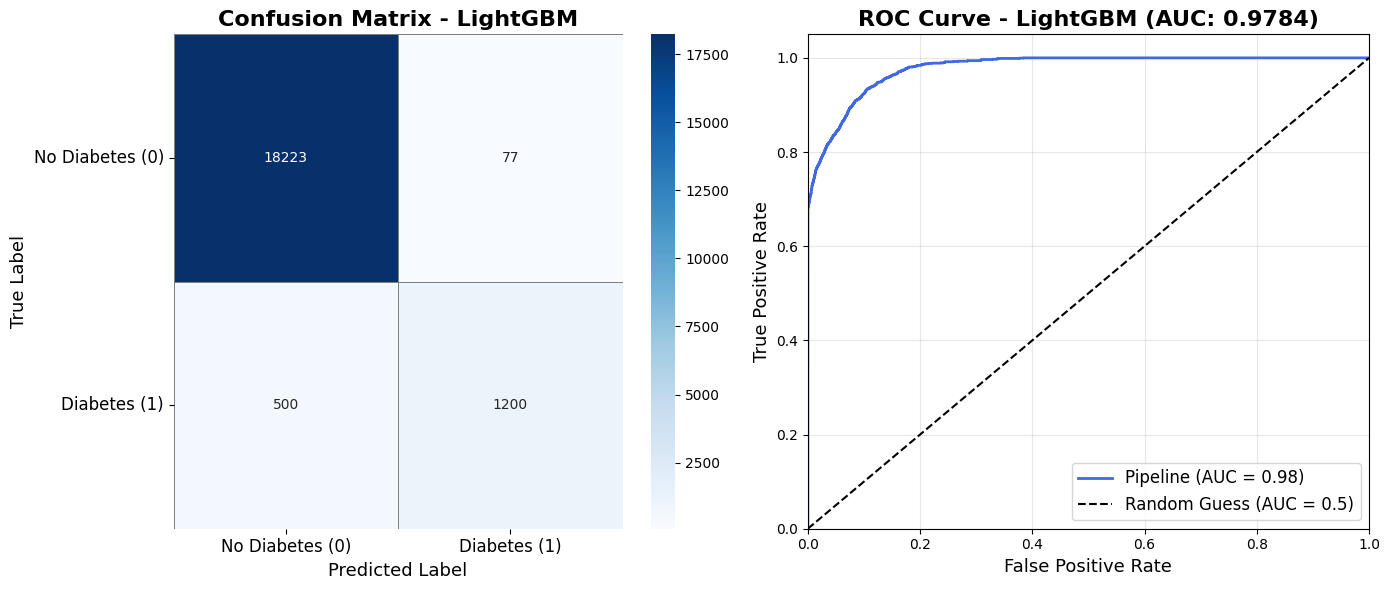

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc

# Confusion matrix
cm = confusion_matrix(y_test, y_pred_lgb)
fpr, tpr, _ = roc_curve(y_test, y_prob_lgb)
roc_auc = auc(fpr, tpr)

# Plot side-by-side
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# 1️⃣ Confusion Matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax[0], cbar=True, linewidths=0.5, linecolor='gray')
ax[0].set_title('Confusion Matrix - LightGBM', fontsize=16, fontweight='bold')
ax[0].set_xlabel('Predicted Label', fontsize=13)
ax[0].set_ylabel('True Label', fontsize=13)
ax[0].set_xticklabels(['No Diabetes (0)', 'Diabetes (1)'], fontsize=12)
ax[0].set_yticklabels(['No Diabetes (0)', 'Diabetes (1)'], fontsize=12, rotation=0)

# 2️⃣ ROC Curve
ax[1].plot(fpr, tpr, color='royalblue', lw=2, label=f'Pipeline (AUC = {roc_auc:.2f})')
ax[1].plot([0, 1], [0, 1], color='black', linestyle='--', label='Random Guess (AUC = 0.5)')
ax[1].set_xlim([0.0, 1.0])
ax[1].set_ylim([0.0, 1.05])
ax[1].set_xlabel('False Positive Rate', fontsize=13)
ax[1].set_ylabel('True Positive Rate', fontsize=13)
ax[1].set_title(f'ROC Curve - LightGBM (AUC: {roc_auc:.4f})', fontsize=16, fontweight='bold')
ax[1].legend(loc="lower right", fontsize=12)
ax[1].grid(alpha=0.3)

# Tight layout
plt.tight_layout()
plt.show()


In [6]:
# --- START: Added code to save the best model ---
print("\n--- Saving the Optimized LightGBM Model ---")
joblib.dump(best_lgb_model, "optimized_lightgbm_model.pkl")
print("Model saved as 'optimized_lightgbm_model.pkl'")


--- Saving the Optimized LightGBM Model ---
Model saved as 'optimized_lightgbm_model.pkl'
